# Link Prediction w/ n2v

In [ ]:
# !pip install arxiv

You can install the arxiv package in Python with the following command:  
`pip install arxiv`  
or follow the instructions here : https://pypi.org/project/arxiv/  

## What is Link Prediction?



## Cold Start Problem in Recommendation Systems

In [1]:
import networkx as nx
import scipy as sp
import pandas as pd
import numpy as np
import arxiv

from node2vec import Node2Vec as n2v
from node2vec.edges import HadamardEmbedder

In [2]:
# constants
queries = [
    'automl', 'machinelearning', 'data', 'phyiscs','mathematics', 'recommendation system', 'nlp', 'neural networks'
]

# Fetch Data

We want to hit th Arxiv API to gather some information about the latest research papers based on the queries we've identified above. This will allow us to then create a network from this research paper data and then we can try to predict links on that network. For the purposes of this article, I will search for a maximum of 1000 results per query, but you don't have to set yourself to the same constraints. The Arxiv API allows users to hit up to 300,000 results per query. The function outlined below will generate a CSV fetching the following information :   
```'title', 'date', 'article_id', 'url', 'main_topic', 'all_topics', 'authors', 'year'```   
You are able to fetch more information like the `links, summary, article` but I decided not to since those features won't really be used for the purposes of this analysis and tutorial.

For reference to the Arxiv API, you can find their detailed documentation here : https://arxiv.org/help/api/user-manual

In [3]:
def search_arxiv(queries, max_results = 1000):
    '''
    This function will search arxiv associated to a set of queries and store
    the latest 10000 (max_results) associated to that search.
    
    params:
        queries (List -> Str) : A list of strings containing keywords you want
                                to search on Arxiv
        max_results (Int) : The maximum number of results you want to see associated
                            to your search. Default value is 1000, capped at 300000
                            
    returns:
        This function will return a DataFrame holding the following columns associated
        to the queries the user has passed. 
            `title`, `date`, `article_id`, `url`, `main_topic`, `all_topics`
    
    example:
        research_df = search_arxiv(
            queries = ['automl', 'recommender system', 'nlp', 'data science'],
            max_results = 10000
        )
    '''
    d = []
    searches = []
    # hitting the API
    for query in queries:
        search = arxiv.Search(
          query = query,
          max_results = max_results,
          sort_by = arxiv.SortCriterion.SubmittedDate,
          sort_order = arxiv.SortOrder.Descending
        )
        searches.append(search)
    
    # Converting search result into df
    for search in searches:
        for res in search.results():
            data = {
                'title' : res.title,
                'date' : res.published,
                'article_id' : res.entry_id,
                'url' : res.pdf_url,
                'main_topic' : res.primary_category,
                'all_topics' : res.categories,
                'authors' : res.authors
            }
            d.append(data)
        
    d = pd.DataFrame(d)
    d['year'] = pd.DatetimeIndex(d['date']).year
    
    # change article id from url to integer
    unique_article_ids = d.article_id.unique()
    article_mapping = {art:idx for idx,art in enumerate(unique_article_ids)}
    d['article_id'] = d['article_id'].map(article_mapping)
    return d

In [4]:
%%time
research_df = search_arxiv(
    queries = queries,
    max_results = 100
)
research_df.shape

CPU times: user 975 ms, sys: 46.6 ms, total: 1.02 s
Wall time: 8.19 s


(646, 8)

If you're having trouble querying the data, for reproducibility purposes, the CSV I used for the analysis conducted in this article was uploaded to my GitHub which you can find here. https://github.com/vatsal220/medium_articles/blob/main/link_prediction/data/arxiv_data.csv

## Generate Network

Now that we've fetched the data using the Arxiv API, we can generate a network. The network will have the following structure, nodes will be the article_ids and the edges will be all topics connecting a pair of articles. For example, article_id 1 with the following topics `astro-physics, and stats` can be connected to article_id 10 with the topic `stats` and article_id 7 with the topics `astro-physics, math`. This will be a multi-edge network where each edge will hold a weight of 1.

In [5]:
r_df = research_df.explode('all_topics').copy()

In [6]:
def generate_network(df, node_col = 'article_id', edge_col = 'main_topic'):
    '''
    This function will generate a article to article network given an input DataFrame.
    It will do so by creating an edge_dictionary where each key is going to be a node
    referenced by unique values in node_col and the values will be a list of other nodes
    connected to the key through the edge_col.
    
    params:
        df (DataFrame) : The dataset which holds the node and edge columns
        node_col (String) : The column name associated to the nodes of the network
        edge_col (String) : The column name associated to the edges of the network
        
    returns:
        A networkx graph corresponding to the input dataset
        
    example:
        generate_network(
            research_df,
            node_col = 'article_id',
            edge_col = 'main_topic'
        )
    '''
    edge_dct = {}
    for i,g in df.groupby(node_col):
        topics = df[edge_col].unique()
        edge_df = df[(df[node_col] != i) & (df[edge_col].isin(topics))]
        edges = list(edge_df[node_col].unique())
        edge_dct[i] = edges
    
    # create nx network
    g = nx.Graph(edge_dct)
    return g

In [7]:
%time research_network = generate_network(research_df, node_col = 'article_id', edge_col = 'main_topic')

CPU times: user 732 ms, sys: 47.6 ms, total: 780 ms
Wall time: 824 ms


In [8]:
print(nx.info(research_network))

Name: 
Type: Graph
Number of nodes: 548
Number of edges: 149878
Average degree: 547.0000


In [9]:
%time all_topic_nx = generate_network(r_df, node_col = 'article_id', edge_col = 'all_topics')

CPU times: user 721 ms, sys: 18.2 ms, total: 739 ms
Wall time: 739 ms


In [10]:
print(nx.info(all_topic_nx))

Name: 
Type: Graph
Number of nodes: 548
Number of edges: 149878
Average degree: 547.0000


In [1]:
from stellargraph.data import EdgeSplitter
from stellargraph import StellarGraph

edgeSplitter = EdgeSplitter(G)
graph_test, samples_test, labels_test = edgeSplitter.train_test_split(p=0.1, method="global", seed=24)
edgeSplitter = EdgeSplitter(graph_test, G)

## Node2Vec

This component will cover running node2vec on the graph generated above and creating the associated node embeddings for that network. These embeddings will play a crucial role coming up as they're the main features necessary for building a link prediction model.

In [15]:
%time g_emb = n2v(research_network, dimensions=16)

Computing transition probabilities:   0%|          | 0/562 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:25<00:00,  2.55s/it]

CPU times: user 5min 57s, sys: 4.73 s, total: 6min 2s
Wall time: 6min 3s


In [16]:
WINDOW = 1 # Node2Vec fit window
MIN_COUNT = 1 # Node2Vec min. count
BATCH_WORDS = 4 # Node2Vec batch words

In [17]:
mdl = g_emb.fit(
    window=WINDOW,
    min_count=MIN_COUNT,
    batch_words=BATCH_WORDS
)

In [18]:
input_node = '1'
for s in mdl.wv.most_similar(input_node, topn = 10):
    print(s)

('211', 0.9128776788711548)
('521', 0.911181628704071)
('40', 0.9052026271820068)
('124', 0.9023550152778625)
('287', 0.9022865891456604)
('132', 0.8979486227035522)
('138', 0.8978955745697021)
('467', 0.8966530561447144)
('170', 0.8965973854064941)
('531', 0.8943594098091125)


In [22]:
r_df[r_df.article_id == 1]

,title,date,article_id,url,main_topic,all_topics,authors,year
1,Hubble Asteroid Hunter: I. Identifying asteroi...,2022-02-01 06:56:20+00:00,1,http://arxiv.org/pdf/2202.00246v1,astro-ph.EP,astro-ph.EP,"[Sandor Kruk, Pablo García Martín, Marcel Pope...",2022
1,Hubble Asteroid Hunter: I. Identifying asteroi...,2022-02-01 06:56:20+00:00,1,http://arxiv.org/pdf/2202.00246v1,astro-ph.EP,astro-ph.IM,"[Sandor Kruk, Pablo García Martín, Marcel Pope...",2022


In [24]:
r_df[r_df.article_id == 521]

,title,date,article_id,url,main_topic,all_topics,authors,year
577,Topological Defects Induced High-Spin Quartet ...,2022-02-08 13:34:05+00:00,521,http://arxiv.org/pdf/2202.03853v1,cond-mat.mes-hall,cond-mat.mes-hall,"[Can Li, Yu Liu, Yufeng Liu, Fu-Hua Xue, Danda...",2022


## Generate Embeddings DataFrame

HammardEmbedder is a built in function in the Node2Vec module which will map each edge in the graph to a 2 dimensional vector.

In [27]:
edges_embs = HadamardEmbedder(keyed_vectors=mdl.wv)

In [34]:
x=[1,2]
edges_embs[str(x[0]),str(x[1])]

array([-3.7655393e-03, -2.8567361e-03,  4.9281660e-03,  9.7447746e-03,
        3.7780097e-01,  1.0559981e-01,  9.0187088e-02,  2.1004081e-01,
       -9.8845344e-03,  4.4821419e-02,  8.9732967e-03,  1.9710543e-04,
       -2.1407234e-02,  1.5342700e-02,  7.0044226e-03,  2.9080274e-04],
      dtype=float32)

In [20]:
emb_df = (
    pd.DataFrame(
        [mdl.wv.get_vector(str(n)) for n in research_network.nodes()],
        index = research_network.nodes
    )
)

In [21]:
emb_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.128435,-0.049074,0.132459,-0.102469,0.844356,0.267155,0.225001,-0.419419,-0.135403,-0.002126,-0.086459,-0.163671,-0.006720,0.043489,0.237503,0.019430
1,0.096374,0.018799,0.035309,-0.023356,0.524462,0.257324,0.579559,-0.595028,-0.237835,-0.113283,0.068707,-0.420708,0.095696,-0.093512,0.159015,0.001616
2,-0.039072,-0.151964,0.139572,-0.417229,0.720359,0.410377,0.155613,-0.352993,0.041561,-0.395659,0.130601,-0.000469,-0.223700,-0.164071,0.044049,0.179982
3,0.163633,0.070856,-0.186758,-0.188014,0.689734,0.305346,0.171601,-0.403026,-0.155164,-0.409362,0.080607,-0.192482,0.092849,0.082888,0.109581,0.110443
4,0.094581,-0.131820,0.265450,-0.071456,0.753454,0.235651,0.430763,-0.240429,-0.041164,-0.160510,-0.171398,-0.306116,0.137343,-0.272153,0.346461,0.089041


## Train Model

In [ ]:
train_embeddings = [edges_embs[str(x[0]),str(x[1])] for x in samples_train]

## Model Performance

## Generate Predictions

---

In [2]:
import networkx as nx
import numpy as np

In [4]:
arr = np.array([[4,8],[3,7]])

In [8]:
g = nx.convert_matrix.from_numpy_array(arr)

In [9]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 2
Number of edges: 3
Average degree:   3.0000


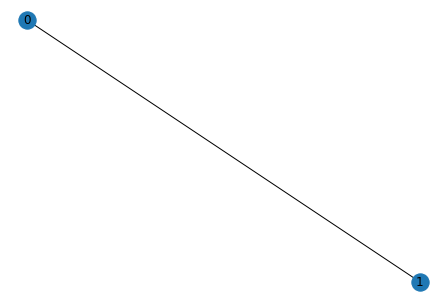

In [12]:
nx.draw(g, with_labels = True)

In [22]:
mat1 = np.array([[0,2,3,0], [2,0,1,1], [3,1,0,0], [0,1,0,0]])
mat2 = np.array([[0,4,5,3], [4,0,1,2], [5,1,0,0], [3,2,0,0]])

In [23]:
mat1@mat2

array([[23,  3,  2,  4],
       [ 8, 11, 10,  6],
       [ 4, 12, 16, 11],
       [ 4,  0,  1,  2]])

In [24]:
mat1.dot(mat2)

array([[23,  3,  2,  4],
       [ 8, 11, 10,  6],
       [ 4, 12, 16, 11],
       [ 4,  0,  1,  2]])

In [18]:
mat1*mat2

array([[ 0,  8, 15],
       [ 8,  0,  1],
       [15,  1,  0]])

In [19]:
mat1 = np.array([[0,2], [2,0]])
mat2 = np.array([[0,4], [4,0]])

In [20]:
mat1@mat2

array([[8, 0],
       [0, 8]])

In [21]:
mat1*mat2

array([[0, 8],
       [8, 0]])